In [7]:
import importlib
import sys
# Remove from cache to force reload
if 'terrain' in sys.modules:
    del sys.modules['terrain']
import terrain
importlib.reload(terrain)
import dynamics
importlib.reload(dynamics)

<module 'dynamics' from '/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/era5vis-main/era5vis/dynamics.py'>

In [5]:
# Load terrain data from the 30m GeoTiff
terrain_data, lats, lons, resolution_m = terrain.load_terrain_from_tif()

print(f"\nTerrain shape: {terrain_data.shape}")
print(f"Resolution: ~{resolution_m}m")
print(f"Elevation range: {terrain_data.min()}m to {terrain_data.max()}m")

Initial scan: 4961595 no-data pixels detected
  All no-data filled after 8 iterations
  All no-data filled after 8 iterations
Loaded terrain: (7641, 25469), resolution ~30m
  Bounds: lat(45.00, 48.00), lon(6.00, 16.00)
  No-data pixels filled: 4961595 (2.55%)
Loaded terrain: (7641, 25469), resolution ~30m
  Bounds: lat(45.00, 48.00), lon(6.00, 16.00)
  No-data pixels filled: 4961595 (2.55%)
  Elevation range: 0m to 4672m
  Elevation range: 0m to 4672m
  Mean elevation: 921.7m
  Mean elevation: 921.7m
  Remaining no-data (negative) pixels: 0

Terrain shape: (7641, 25469)
Resolution: ~30m
  Remaining no-data (negative) pixels: 0

Terrain shape: (7641, 25469)
Resolution: ~30m
Elevation range: 0m to 4672m
Elevation range: 0m to 4672m


In [ ]:
# Downsample to 1km resolution
terrain_1km, lats_1km, lons_1km, resolution_1km = terrain.downsample_terrain(
    terrain_data, lats, lons, resolution_m, target_resolution_m=1000
)

print(f"\n1km terrain shape: {terrain_1km.shape}")
print(f"Resolution: ~{resolution_1km}m")

Downsampled: (7641, 25469) -> (46, 153), resolution ~5010m
  Elevation range: 0m to 3661m

1km terrain shape: (46, 153)
Resolution: ~5010m


In [28]:
# Compute terrain aspect dataset
terrain_ds = terrain.compute_terrain_aspect_dataset(
    terrain=terrain_1km,
    lats=lats_1km,
    lons=lons_1km,
    resolution_m=resolution_1km,
    min_elevation=50.0,
    min_slope=3.0
)



In [29]:
terrain_ds

<xarray.Dataset> Size: 93kB
Dimensions:       (latitude: 46, longitude: 153)
Coordinates:
  * latitude      (latitude) float64 368B 48.0 47.93 47.87 ... 45.13 45.07 45.0
  * longitude     (longitude) float64 1kB 6.0 6.066 6.132 ... 15.87 15.93 16.0
Data variables:
    elevation     (latitude, longitude) int32 28kB 335 345 389 ... 295 392 490
    aspect_deg    (latitude, longitude) int32 28kB 335 331 321 ... 206 205 200
    slope         (latitude, longitude) int32 28kB 0 0 0 0 0 1 1 ... 1 0 0 0 0 0
    terrain_mask  (latitude, longitude) bool 7kB False False ... False False
Attributes:
    resolution_m:   5010
    min_elevation:  50.0
    min_slope:      3.0
    description:    Terrain slope aspect dataset computed from SRTM data

In [ ]:
# Save terrain aspect dataset to NetCDF
output_path = "./terrain_cache/terrain_aspect_1km.nc"
terrain_ds.to_netcdf(output_path)
print(f"Saved terrain aspect dataset to {output_path}")

Saved terrain aspect dataset to ./terrain_cache/terrain_aspect_5km.nc


In [3]:
# Load terrain aspect dataset (pre-computed 1km)
terrain_ds = terrain.load_terrain_aspect_dataset()
terrain_ds

<xarray.Dataset> Size: 6MB
Dimensions:       (latitude: 232, longitude: 772)
Coordinates:
  * latitude      (latitude) float64 2kB 48.0 47.99 47.97 ... 45.03 45.01 45.0
  * longitude     (longitude) float64 6kB 6.0 6.013 6.026 ... 15.97 15.99 16.0
Data variables:
    elevation     (latitude, longitude) float64 1MB ...
    aspect        (latitude, longitude) float64 1MB ...
    aspect_deg    (latitude, longitude) float64 1MB ...
    slope         (latitude, longitude) float64 1MB ...
    terrain_mask  (latitude, longitude) bool 179kB ...
Attributes:
    resolution_m:       990
    min_elevation:      500.0
    min_slope:          1.0
    description:        Terrain slope aspect dataset computed from SRTM data
    aspect_convention:  Downhill direction in radians, 0=North, π/2=East, ±π=...

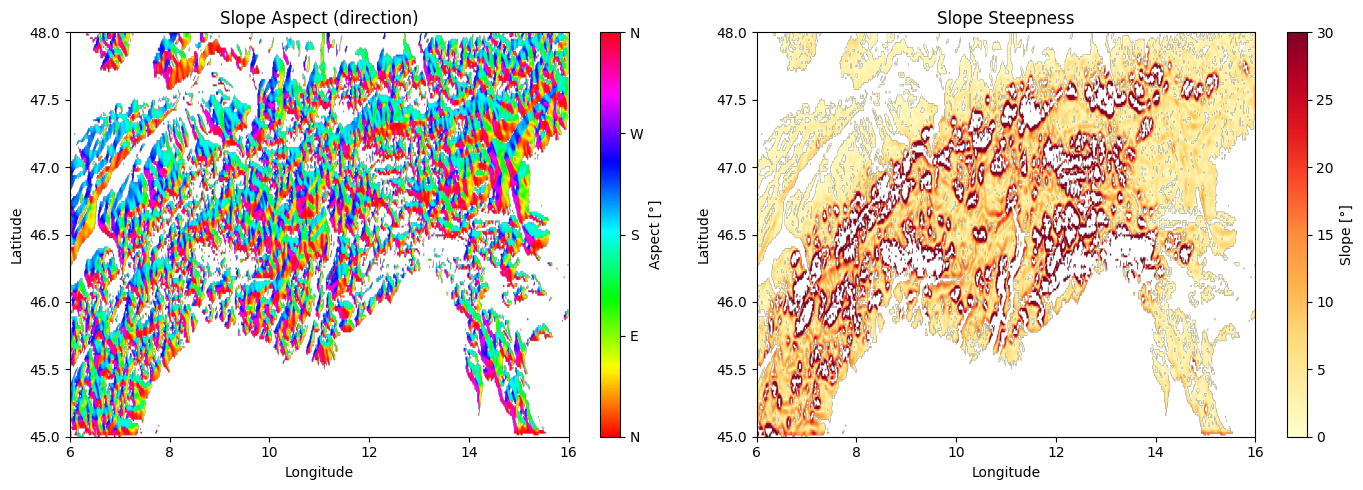

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get coordinates from the terrain_ds dataset
lons_plot = terrain_ds.longitude.values
lats_plot = terrain_ds.latitude.values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Aspect plot (circular colormap)
ax1 = axes[0]
aspect_data = np.where(terrain_ds['terrain_mask'].values, terrain_ds['aspect_deg'].values, np.nan)
im1 = ax1.imshow(aspect_data, extent=[lons_plot[0], lons_plot[-1], lats_plot[-1], lats_plot[0]], 
                  cmap='hsv', vmin=0, vmax=360, aspect='auto')
ax1.set_title('Slope Aspect (direction)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cbar1 = plt.colorbar(im1, ax=ax1, label='Aspect [°]', ticks=[0, 90, 180, 270, 360])
cbar1.ax.set_yticklabels(['N', 'E', 'S', 'W', 'N'])

# Slope plot
ax2 = axes[1]
slope_data = np.where(terrain_ds['terrain_mask'].values, terrain_ds['slope'].values, np.nan)
im2 = ax2.imshow(slope_data, extent=[lons_plot[0], lons_plot[-1], lats_plot[-1], lats_plot[0]], 
                  cmap='YlOrRd', vmin=0, vmax=30, aspect='auto')
ax2.set_title('Slope Steepness')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Slope [°]')

plt.tight_layout()
plt.show()


In [9]:
##Example usage to add terrain intersection to ERA5 data
import xarray as xr
terrain_ds = terrain.load_terrain_aspect_dataset()
era5_path = "./data/era5_example_dataset.nc"
era5_data = xr.open_dataset(era5_path)
## add geopotential height to ds
era5_data['gph'] = dynamics.geopotential_height(era5_data['z'])



# Crop ERA5 to terrain extent to reduce computation
terrain_lats = terrain_ds.latitude.values
terrain_lons = terrain_ds.longitude.values
lat_min, lat_max = terrain_lats.min(), terrain_lats.max()
lon_min, lon_max = terrain_lons.min(), terrain_lons.max()

# Select ERA5 data within terrain bounds
era5_data = era5_data.sel(
    latitude=slice(lat_max, lat_min),  # ERA5 lats are decreasing
    longitude=slice(lon_min, lon_max)
)

# Interpolate ERA5 onto terrain grid
era5_on_terrain = terrain.interpolate_to_grid(era5_data, terrain_ds)

era5_with_terrain = terrain.compute_terrain_intersection(era5_on_terrain, terrain_ds)
era5_with_terrain


<xarray.Dataset> Size: 296MB
Dimensions:            (valid_time: 10, pressure_level: 5, latitude: 232,
                        longitude: 772)
Coordinates:
  * valid_time         (valid_time) datetime64[ns] 80B 2025-10-01 ... 2025-10...
  * pressure_level     (pressure_level) float64 40B 925.0 850.0 ... 500.0 300.0
  * latitude           (latitude) float64 2kB 48.0 47.99 47.97 ... 45.01 45.0
  * longitude          (longitude) float64 6kB 6.0 6.013 6.026 ... 15.99 16.0
    number             int64 8B ...
    expver             (valid_time) <U4 160B ...
Data variables:
    z                  (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    u                  (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    v                  (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    gph                (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    terrain            (valid_time, pressure_level, latitude, longitude) bool 9MB ...
    terrain_elevation  (latitude, longitude) int32 716kB 325 324 316 ... -1168 0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-05T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
terrain_ds.elevation.where(terrain_ds.elevation < 0).count()
terrain_ds.elevation.count()

<xarray.DataArray 'elevation' ()> Size: 8B
array(179104)
Attributes:
    units:      m
    long_name:  Terrain elevation

In [19]:
terrain_data.max()

np.int16(4672)

In [21]:

# Diagnose the negative altitude issue
import numpy as np

print("=== TIFF Data Diagnostic ===")
print(f"Data type: {terrain_data.dtype}")
print(f"Min value: {terrain_data.min()}")
print(f"Max value: {terrain_data.max()}")
print(f"Mean value: {terrain_data.mean():.2f}")
print(f"Median value: {np.median(terrain_data):.2f}")

# Count no-data values (typically -32768 for int16)
no_data_mask = terrain_data == -32768
no_data_count = no_data_mask.sum()
total_pixels = terrain_data.size
no_data_pct = 100 * no_data_count / total_pixels

print(f"\nNo-data pixels (-32768): {no_data_count} ({no_data_pct:.2f}%)")

# Show distribution of negative values
negative_mask = terrain_data < 0
negative_count = negative_mask.sum()
print(f"Total negative elevation pixels: {negative_count} ({100*negative_count/total_pixels:.2f}%)")

# Estimate valid elevation range
valid_data = terrain_data[~no_data_mask]
if len(valid_data) > 0:
    print(f"\nValid elevation range: {valid_data.min()}m to {valid_data.max()}m")
    print(f"Valid data mean: {valid_data.mean():.2f}m")
    print(f"Valid data median: {np.median(valid_data):.2f}m")


=== TIFF Data Diagnostic ===
Data type: int16
Min value: -32768
Max value: 4672
Mean value: 318.52
Mean value: 318.52
Median value: 714.00
Median value: 714.00

No-data pixels (-32768): 3503120 (1.80%)

No-data pixels (-32768): 3503120 (1.80%)
Total negative elevation pixels: 4961595 (2.55%)
Total negative elevation pixels: 4961595 (2.55%)

Valid elevation range: -32m to 4672m

Valid elevation range: -32m to 4672m
Valid data mean: 925.02m
Valid data mean: 925.02m
Valid data median: 728.00m
Valid data median: 728.00m


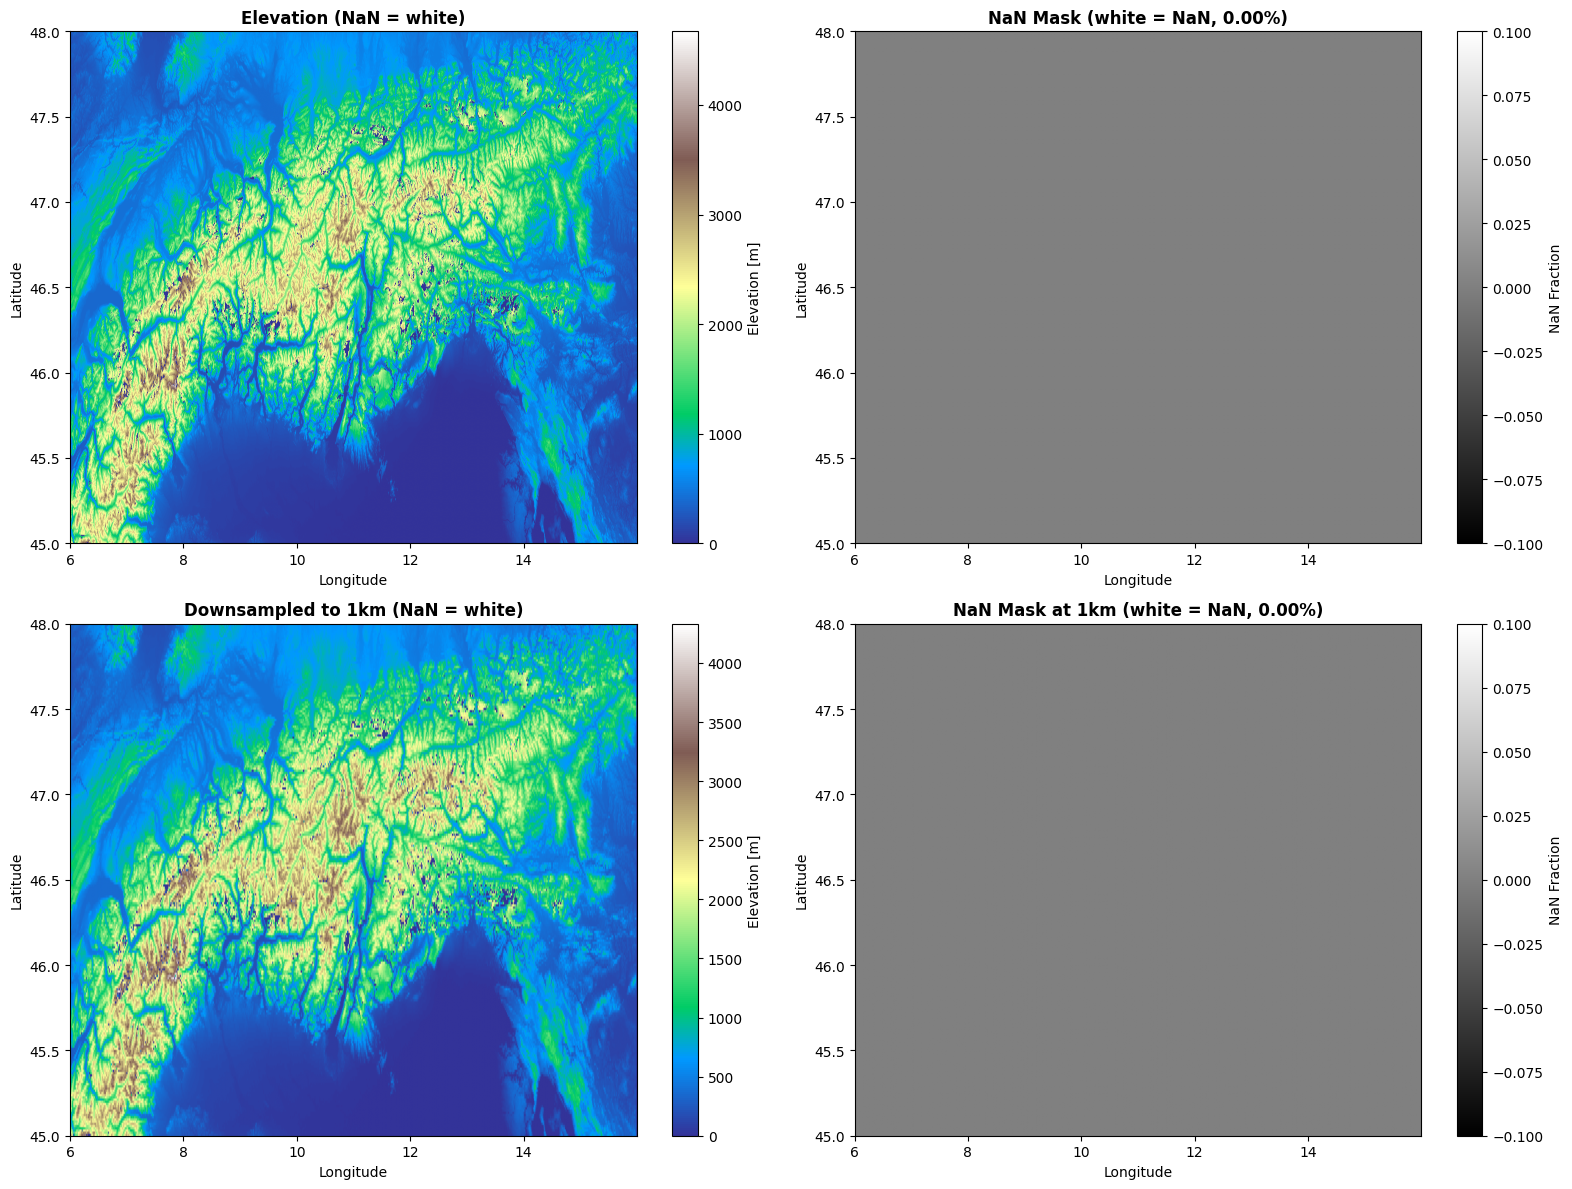


=== NaN Statistics ===
Original 30m terrain:
  Total NaN pixels: 0 (0.00%)
  Valid elevation range: 0m to 4672m

Downsampled 1km terrain:
  Total NaN pixels: 0 (0.00%)
  Valid elevation range: 0m to 4331m


In [8]:

# Visualize NaN distribution in the terrain data
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Elevation with NaN shown as white
ax1 = axes[0, 0]
terrain_display = terrain_data.copy()
im1 = ax1.imshow(terrain_display, extent=[lons[0], lons[-1], lats[-1], lats[0]], 
                  cmap='terrain', aspect='auto')
ax1.set_title('Elevation (NaN = white)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cbar1 = plt.colorbar(im1, ax=ax1, label='Elevation [m]')

# Plot 2: NaN mask (white = NaN, black = valid)
ax2 = axes[0, 1]
nan_mask_display = np.isnan(terrain_data).astype(float)
im2 = ax2.imshow(nan_mask_display, extent=[lons[0], lons[-1], lats[-1], lats[0]], 
                  cmap='gray', aspect='auto')
ax2.set_title(f'NaN Mask (white = NaN, {nan_mask_display.mean()*100:.2f}%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='NaN Fraction')

# Plot 3: Downsampled terrain
ax3 = axes[1, 0]
im3 = ax3.imshow(terrain_1km, extent=[lons_1km[0], lons_1km[-1], lats_1km[-1], lats_1km[0]], 
                  cmap='terrain', aspect='auto')
ax3.set_title('Downsampled to 1km (NaN = white)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
cbar3 = plt.colorbar(im3, ax=ax3, label='Elevation [m]')

# Plot 4: NaN mask at 1km resolution
ax4 = axes[1, 1]
nan_mask_1km = np.isnan(terrain_1km).astype(float)
im4 = ax4.imshow(nan_mask_1km, extent=[lons_1km[0], lons_1km[-1], lats_1km[-1], lats_1km[0]], 
                  cmap='gray', aspect='auto')
ax4.set_title(f'NaN Mask at 1km (white = NaN, {nan_mask_1km.mean()*100:.2f}%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='NaN Fraction')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== NaN Statistics ===")
print(f"Original 30m terrain:")
print(f"  Total NaN pixels: {np.isnan(terrain_data).sum()} ({np.isnan(terrain_data).mean()*100:.2f}%)")
print(f"  Valid elevation range: {np.nanmin(terrain_data):.0f}m to {np.nanmax(terrain_data):.0f}m")

print(f"\nDownsampled 1km terrain:")
print(f"  Total NaN pixels: {np.isnan(terrain_1km).sum()} ({np.isnan(terrain_1km).mean()*100:.2f}%)")
print(f"  Valid elevation range: {np.nanmin(terrain_1km):.0f}m to {np.nanmax(terrain_1km):.0f}m")


In [ ]:

# Final verification
print("=== FINAL VERIFICATION ===")
print(f"\nOriginal 30m terrain:")
print(f"  Shape: {terrain_data.shape}")
print(f"  Data type: {terrain_data.dtype}")
print(f"  Min: {terrain_data.min()}m")
print(f"  Max: {terrain_data.max()}m")
print(f"  Mean: {terrain_data.mean():.1f}m")
print(f"  Negative values: {(terrain_data < 0).sum()}")

print(f"\nDownsampled 1km terrain:")
print(f"  Shape: {terrain_1km.shape}")
print(f"  Data type: {terrain_1km.dtype}")
print(f"  Min: {terrain_1km.min()}m")
print(f"  Max: {terrain_1km.max()}m")
print(f"  Mean: {terrain_1km.mean():.1f}m")
print(f"  Negative values: {(terrain_1km < 0).sum()}")

print(f"\nTerrain dataset (xarray):")
print(f"  Elevation min/max: {terrain_ds['elevation'].min().values}m / {terrain_ds['elevation'].max().values}m")
print(f"  Valid terrain mask: {terrain_ds['terrain_mask'].sum().values} pixels")
